# Librerías

In [1]:
import pandas as pd
import numpy as np

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from varclushi import VarClusHi

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#from scikitplot.metrics import plot_roc_curve

In [2]:
pd.set_option('display.max_columns',100)

In [3]:
pd.options.display.float_format = '{:,.6f}'.format

# Extracción de datos

In [4]:
ruta  = 'data/estaciones'

In [7]:
lst_archivos = os.listdir( ruta )

In [10]:
archi = [ a for a in  lst_archivos if a[-3:] == 'csv']

In [18]:
df = pd.read_csv( os.path.join( ruta , archi[0]  ) , sep='|' )

In [20]:
df.sample(10)

,afluencia,id_estacion,t
195307,583168,Est00067,67
227834,23826,Est00138,360
37632,152497,Est00011,228
25907,425439,Est00114,21
62523,188247,Est00123,632
25379,52836,Est00118,664
61056,138583,Est00160,496
219131,130865,Est00050,252
59440,54441,Est00293,531
225355,115332,Est00119,348


# Planteamiento de los problemas

Clara nos solicitó resolver esta problemática para todas las estaciones a nivel nacional:
1) Pronósticar la afluencia de cualquier estación
2) Identificar si alguna estación será de alta demanda o no ( 0 = Baja demanda , 1 = Alta demanda  )

Las dos problemáticas son de tipo MODELOS SUPERVISADOS
1) Es un modelo de regresión
2) Es un modelo de clasificación

# Limpieza / Exploración

In [21]:
df.dtypes

afluencia       int64
id_estacion    object
t               int64
dtype: object

In [24]:
df['id_estacion'].value_counts()

id_estacion
Est00185    700
Est00194    700
Est00007    700
Est00117    700
Est00251    700
           ... 
Est00052    699
Est00239    699
Est00104    699
Est00250    699
Est00320    699
Name: count, Length: 390, dtype: int64

# Variables

In [63]:
um = ['id_estacion']

In [ ]:
t_min = df['t'].min() 
t_max = df['t'].max()
cols = range( t_min , t_max+1 )

In [36]:
t_min, t_max

(np.int64(1), np.int64(700))

In [37]:
df_piv = df.pivot_table( index=um , columns='t' , values='afluencia', aggfunc ='sum' ).reset_index()

In [38]:
df_piv

t,id_estacion,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700
0,Est00000,"39,059.000000","74,700.000000","44,356.000000","237,597.000000","235,918.000000","181,140.000000","257,563.000000","257,761.000000","142,208.000000","68,416.000000","233,986.000000","297,135.000000","244,377.000000","213,395.000000","284,806.000000","191,722.000000","90,565.000000","284,391.000000","286,159.000000","265,663.000000","308,424.000000","278,298.000000","145,315.000000","114,979.000000","246,934.000000","196,434.000000","282,779.000000","257,312.000000","337,761.000000","193,769.000000","72,877.000000","99,671.000000","257,584.000000","334,456.000000","249,029.000000","309,451.000000","208,369.000000","82,072.000000","263,976.000000","347,139.000000","247,580.000000","319,318.000000","353,565.000000","146,118.000000","99,440.000000","365,255.000000","295,789.000000","267,934.000000","276,156.000000",...,"301,889.000000","369,308.000000","271,865.000000","123,949.000000","424,303.000000","328,247.000000","308,635.000000","297,251.000000","308,274.000000","236,271.000000","106,873.000000","387,071.000000","332,824.000000","309,247.000000","313,830.000000","354,558.000000","247,682.000000","115,516.000000","405,568.000000","315,027.000000","159,651.000000","329,464.000000","321,943.000000","222,915.000000","113,659.000000","379,849.000000","320,937.000000","309,172.000000","297,774.000000","320,161.000000","238,135.000000","122,480.000000","414,973.000000","396,088.000000","373,579.000000","336,115.000000","329,641.000000","248,852.000000","112,633.000000","139,188.000000","370,097.000000","305,425.000000","311,695.000000","325,139.000000","240,916.000000","110,586.000000","394,055.000000","343,256.000000","374,973.000000","359,923.000000"
1,Est00001,"48,321.000000","368,193.000000","293,510.000000","295,068.000000","200,780.000000","236,938.000000","152,211.000000","283,677.000000","114,380.000000","365,221.000000","290,042.000000","143,983.000000","91,633.000000","242,494.000000","269,491.000000","330,437.000000","305,608.000000","287,825.000000","165,424.000000","109,593.000000","251,436.000000","285,139.000000","258,189.000000","282,038.000000","266,003.000000","165,798.000000","94,217.000000","355,734.000000","355,945.000000","314,483.000000","342,847.000000","124,799.000000","240,535.000000","213,952.000000","316,645.000000","305,506.000000","103,282.000000","149,137.000000","262,466.000000","345,323.000000","289,464.000000","153,082.000000","284,255.000000","362,637.000000","387,397.000000","376,435.000000","219,807.000000","120,562.000000","355,721.000000",...,"102,962.000000","96,604.000000","115,183.000000","102,452.000000","123,507.000000","97,685.000000","61,051.000000","99,263.000000","104,064.000000","102,922.000000","124,391.000000","119,617.000000","98,093.000000","61,691.000000","99,549.000000","113,755.000000","109,559.000000","103,085.000000","108,165.000000","109,552.000000","51,538.000000","64,696.000000","104,098.000000","107,770.000000","104,071.000000","117,889.000000","94,618.000000","53,455.000000","105,043.000000","109,681.000000","104,642.000000","112,803.000000","122,051.000000","95,292.000000","61,500.000000","74,516.000000","105,091.000000","101,453.000000","107,478.000000","116,556.000000","97,849.000000","51,293.000000","93,265.000000","116,890.000000","116,176.000000","109,783.000000","123,092.000000","79,045.000000","66,206.000000","94,625.000000"
2,Est00002,"17,515.000000","49,586.000000","49,395.000000","42,017.000000","27,076.000000","38,617.000000","33,000.000000","43,166.000000","20,616.000000","54,652.000000","40,779.000000","31,959.000000","21,609.000000","42,513.000000","44,044.000000","46,825.000000","43,221.00000

# Funciones

# Funciones Agregación

In [67]:
def sum_inc(l):
    return sum( [ int(y>x) for x,y in zip(l , l[1:] ) ] )

def sum_dec(l):
    return sum( [ int(y<x) for x,y in zip(l , l[1:] ) ] )

def media_inc(l):
    return np.mean( [ int(y>x) for x,y in zip(l , l[1:] ) ] )

def media_dec(l):
    return np.mean( [ int(y<x) for x,y in zip(l , l[1:] ) ] )

def delta_min(l):
    try:
        return min( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_max(l):
    try:
        return  max( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_mean(l):
    try:
        return  np.mean( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_desv(l):
    try:
        return  np.std( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan
    
def pct_delta_min(l):
    try:
        return  min( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_max(l):
    try:
        return  max( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_mean(l):
    try:
        return  np.mean( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_desv(l):
    try:
        return  np.std( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def max_racha_inc(l):
    return max( [ len(i) for i in "".join([ str( int(y>x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def max_racha_dec(l):
    return max( [ len(i) for i in "".join([ str( int(y<x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def media_racha_inc(l):
    return np.mean( [ len(i) for i in "".join([ str( int(y>x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def media_racha_dec(l):
    return np.mean( [ len(i) for i in "".join([ str( int(y<x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )    

###### Inicio Ejemplo en excel

In [71]:
lst = [1500,1497,2000,3000,3500,4000,1286]

In [72]:
media_racha_inc(lst)

np.float64(1.3333333333333333)

In [ ]:
sum_inc(lst)
sum_dec(lst)
media_inc(lst)
media_dec(lst)
delta_min(lst)
delta_max(lst)
delta_mean(lst)
delta_desv(lst)
pct_delta_min(lst)
pct_delta_max(lst)
pct_delta_mean(lst)
pct_delta_desv(lst)
max_racha_inc(lst)
max_racha_dec(lst)
media_racha_inc(lst)
media_racha_dec(lst)

###### Fin Ejemplo en excel

In [90]:
lst_func = [ 'sum','min','mean','max','std', 
            sum_inc , sum_dec ,  media_inc, media_dec,
            delta_min, delta_max, delta_mean, delta_desv,
            pct_delta_min, pct_delta_max, pct_delta_mean, pct_delta_desv,
            max_racha_inc, max_racha_dec, media_racha_inc, media_racha_dec ]

# Ventanas de tiempo

In [75]:
vdes = 1
vobs = 10

anclai = t_min + vobs -1
anclaf = t_max - vdes

In [76]:
print("Ventanas: ", vdes , " --- ", vobs)

Ventanas:  1  ---  10


In [77]:
print("Anclas: ", anclai , " --- ", anclaf)

Anclas:  10  ---  699


# Matriz de predictoras

In [91]:
%%time
lst_aux = []

for ancla in range(anclai, anclaf + 1):
#for ancla in range(anclai, 15):

    print("Intervalo: ",ancla - anclai, ancla , " Para pronosticar: ", ancla+vdes)

    aux = df[ ( df['t']>  ancla - anclai ) &
              ( df['t']<= ancla )  ].reset_index(drop=True)

    aux = aux.pivot_table( index = um , 
                           values = 'afluencia', 
                           aggfunc = lst_func )
    
    aux.columns = [ f'v_{i}_{j}' for i,j in aux.columns ]

    aux.insert( 0 , 'ancla' , ancla )
     
    aux.reset_index(inplace=True)

    #print("Tamaño del dataframe: ",aux.shape)
    #display(aux.head(3))

    lst_aux.append(aux)

Intervalo:  0 10  Para pronosticar:  11
Intervalo:  1 11  Para pronosticar:  12
Intervalo:  2 12  Para pronosticar:  13
Intervalo:  3 13  Para pronosticar:  14
Intervalo:  4 14  Para pronosticar:  15
Intervalo:  5 15  Para pronosticar:  16
Intervalo:  6 16  Para pronosticar:  17
Intervalo:  7 17  Para pronosticar:  18
Intervalo:  8 18  Para pronosticar:  19
Intervalo:  9 19  Para pronosticar:  20
Intervalo:  10 20  Para pronosticar:  21
Intervalo:  11 21  Para pronosticar:  22
Intervalo:  12 22  Para pronosticar:  23
Intervalo:  13 23  Para pronosticar:  24
Intervalo:  14 24  Para pronosticar:  25
Intervalo:  15 25  Para pronosticar:  26
Intervalo:  16 26  Para pronosticar:  27
Intervalo:  17 27  Para pronosticar:  28
Intervalo:  18 28  Para pronosticar:  29
Intervalo:  19 29  Para pronosticar:  30
Intervalo:  20 30  Para pronosticar:  31
Intervalo:  21 31  Para pronosticar:  32
Intervalo:  22 32  Para pronosticar:  33
Intervalo:  23 33  Para pronosticar:  34
Intervalo:  24 34  Para pr

In [92]:
X = pd.concat( lst_aux  , ignore_index=True)

In [93]:
X

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571


# Vector Solución

In [101]:
%%time
lst_aux = []

for ancla in range(anclai, anclaf +1):
#for ancla in range(anclai, 15):

    print("Intervalo: ", ancla - anclai , ancla , " Para pronosticar: ",ancla+vdes)

    aux = df[ (df['t'] > ancla-anclai) & (df['t'] <= ancla + vdes ) ].reset_index(drop=True)
    aux =  aux.pivot_table( index= um , columns='t', values='afluencia' )

    #display(aux)
    aux['y'] = aux[ ancla + vdes ]
    #print("\n")
    #display(aux)
    #print("\n")

    aux = aux[['y']]

    aux.insert( 0 , 'ancla', ancla)

    aux.reset_index(inplace=True)

    lst_aux.append(aux)

Intervalo:  0 10  Para pronosticar:  11
Intervalo:  1 11  Para pronosticar:  12
Intervalo:  2 12  Para pronosticar:  13
Intervalo:  3 13  Para pronosticar:  14
Intervalo:  4 14  Para pronosticar:  15
Intervalo:  5 15  Para pronosticar:  16
Intervalo:  6 16  Para pronosticar:  17
Intervalo:  7 17  Para pronosticar:  18
Intervalo:  8 18  Para pronosticar:  19
Intervalo:  9 19  Para pronosticar:  20
Intervalo:  10 20  Para pronosticar:  21
Intervalo:  11 21  Para pronosticar:  22
Intervalo:  12 22  Para pronosticar:  23
Intervalo:  13 23  Para pronosticar:  24
Intervalo:  14 24  Para pronosticar:  25
Intervalo:  15 25  Para pronosticar:  26
Intervalo:  16 26  Para pronosticar:  27
Intervalo:  17 27  Para pronosticar:  28
Intervalo:  18 28  Para pronosticar:  29
Intervalo:  19 29  Para pronosticar:  30
Intervalo:  20 30  Para pronosticar:  31
Intervalo:  21 31  Para pronosticar:  32
Intervalo:  22 32  Para pronosticar:  33
Intervalo:  23 33  Para pronosticar:  34
Intervalo:  24 34  Para pr

In [102]:
y = pd.concat( lst_aux , ignore_index=True )

In [104]:
X.shape , y.shape

((269100, 23), (269100, 3))

In [83]:
y

NameError: name 'y' is not defined

# TAD preliminar

In [110]:
tad = X.merge( y , on = ['id_estacion','ancla'] , how='inner' )

In [111]:
tad

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia,y
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667,"233,986.000000"
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000,"290,042.000000"
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000,"40,779.000000"
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000,"232,123.000000"
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000,"228,464.000000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,405.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667,"64,261.000000"
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667,NaN
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571,"266,479.000000"


<Axes: >

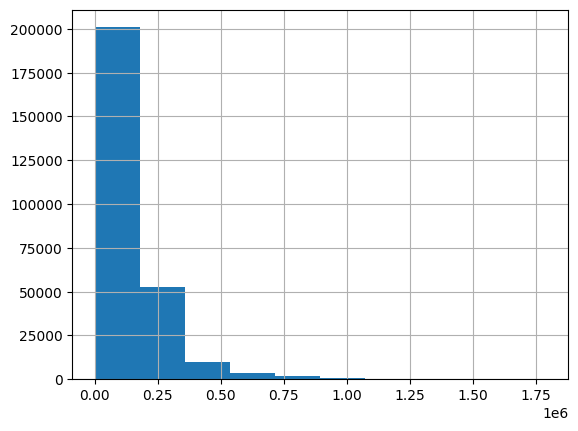

In [112]:
tad['y'].hist()

In [114]:
tad['y2'] = np.where(tad['y'] <= 100000,0,1)

In [10]:
tad['y'].describe(percentiles=np.arange(0,1.01,0.1))

count     268,977.000000
mean      135,353.796012
std       132,691.970460
min           405.000000
0%            405.000000
10%        20,378.000000
20%        40,480.000000
30%        56,325.000000
40%        75,727.000000
50%        99,644.000000
60%       128,416.000000
70%       161,582.000000
80%       202,716.600000
90%       282,528.000000
100%    1,789,298.000000
max     1,789,298.000000
Name: y, dtype: float64

In [11]:
tad['y2'].value_counts(1)*100

y2
0   50.108138
1   49.891862
Name: proportion, dtype: float64

In [85]:
#y = tad[um+['ancla','y'] ]
#y2 = tad[um+['ancla','y2'] ]

In [115]:
tad

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia,y,y2
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667,"233,986.000000",1
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000,"290,042.000000",1
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000,"40,779.000000",0
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000,"232,123.000000",1
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000,"228,464.000000",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,405.000000,0
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667,"64,261.000000",0
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667,NaN,1
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571,"266,479.000000",1


## Persistir TAD

In [116]:
tad.to_parquet( 'resultados/tad_preliminar_estaciones.parquet' )

# Análisis Exploratorio

In [5]:
tad = pd.read_parquet('resultados/tad_preliminar_estaciones.parquet')

## Variables Continuas / Numéricas

In [14]:
varc = tad.filter(like='v_').columns.tolist()

In [15]:
len(varc), varc

(21,
 ['v_sum_afluencia',
  'v_min_afluencia',
  'v_mean_afluencia',
  'v_max_afluencia',
  'v_std_afluencia',
  'v_sum_inc_afluencia',
  'v_sum_dec_afluencia',
  'v_media_inc_afluencia',
  'v_media_dec_afluencia',
  'v_delta_min_afluencia',
  'v_delta_max_afluencia',
  'v_delta_mean_afluencia',
  'v_delta_desv_afluencia',
  'v_pct_delta_min_afluencia',
  'v_pct_delta_max_afluencia',
  'v_pct_delta_mean_afluencia',
  'v_pct_delta_desv_afluencia',
  'v_max_racha_inc_afluencia',
  'v_max_racha_dec_afluencia',
  'v_media_racha_inc_afluencia',
  'v_media_racha_dec_afluencia'])

In [16]:
X = tad[varc]

In [19]:
X[varc].describe(np.arange(0,1.01,0.1))

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
count,"269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000"
mean,"1,353,976.052036","74,334.556949","135,397.605204","176,314.870145","32,691.936392",4.136838,4.328216,0.459649,0.480913,"-73,529.444575","78,576.164987",27.410628,"45,175.752720",-0.450056,1.914913,0.215932,0.728990,1.906618,2.021918,0.794251,0.864254
std,"1,258,339.414943","78,056.226627","125,833.941494","160,028.629071","30,339.372834",1.400780,1.437172,0.155642,0.159686,"72,483.820830","76,551.885142","6,880.685913","42,839.565903",0.186629,22.004384,3.160690,7.339626,0.900628,0.933297,0.398381,0.431557
min,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"-1,333,672.000000",0.000000,"-83,680.000000",0.000000,-0.999461,0.000000,-0.144888,0.000000,0.000000,0.000000,0.000000,0.000000
0%,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"-1,333,672.000000",0.000000,"-83,680.000000",0.000000,-0.999461,0.000000,-0.144888,0.000000,0.000000,0.000000,0.000000,0.000000
10%,"242,595.700000","11,123.000000","24,259.570000","31,368.000000","4,952.480672",3.000000,3.000000,0.333333,0.333333,"-158,287.700000","10,452.000000","-6,097.000000","6,577.618666",-0.671484,0.276334,0.000000,0.169906,1.000000,1.000000,0.428571,0.428571
20%,"441,033.000000","22,269.000000","44,103.300000","56,964.000000","9,634.190093",3.000000,4.000000,0.333333,0.444444,"-112,554.000000","21,415.000000","-2,708.888889","12,916.658014",-0.602412,0.485724,0.016730,0.245647,1.000000,1.000000,0.428571,0.666667
30%,"593,347.500000","31,544.000000","59,334.750000","78,399.000000","13,782.952565",4.000000,4.000000,0.444444,0.444444,"-87,814.000000","31,520.000000","-1,181.000000","18,714.200742",-0.550632,0.649315,0.035868,0.301991,2.000000,2.000000,0.666667,0.666667
40%,"815,632.200000","41,283.000000","81,563.220000","106,750.000000","18,903.957295",4.000000,4.000000,0.444444,0.444444,"-69,337.000000","43,346.000000",-343.000000,"25,575.884544",-0.506070,0.800907,0.053591,0.354695,2.000000,2.000000,0.666667,0.666667
50%,"1,058,983.000000","52,517.000000","105,898.300000","139,535.000000","24,857.544785",4.000000,5.000000,0.444444,0.555556,"-53,825.000000","57,559.000000",0.000000,"33,816.295160",-0.465174,0.956109,0.072701,0.409321,2.000000,2.000000,0.666667,1.000000


array([[<Axes: title={'center': 'v_std_afluencia'}>,
        <Axes: title={'center': 'v_sum_inc_afluencia'}>],
       [<Axes: title={'center': 'v_sum_dec_afluencia'}>,
        <Axes: title={'center': 'v_media_inc_afluencia'}>],
       [<Axes: title={'center': 'v_media_dec_afluencia'}>, <Axes: >]],
      dtype=object)

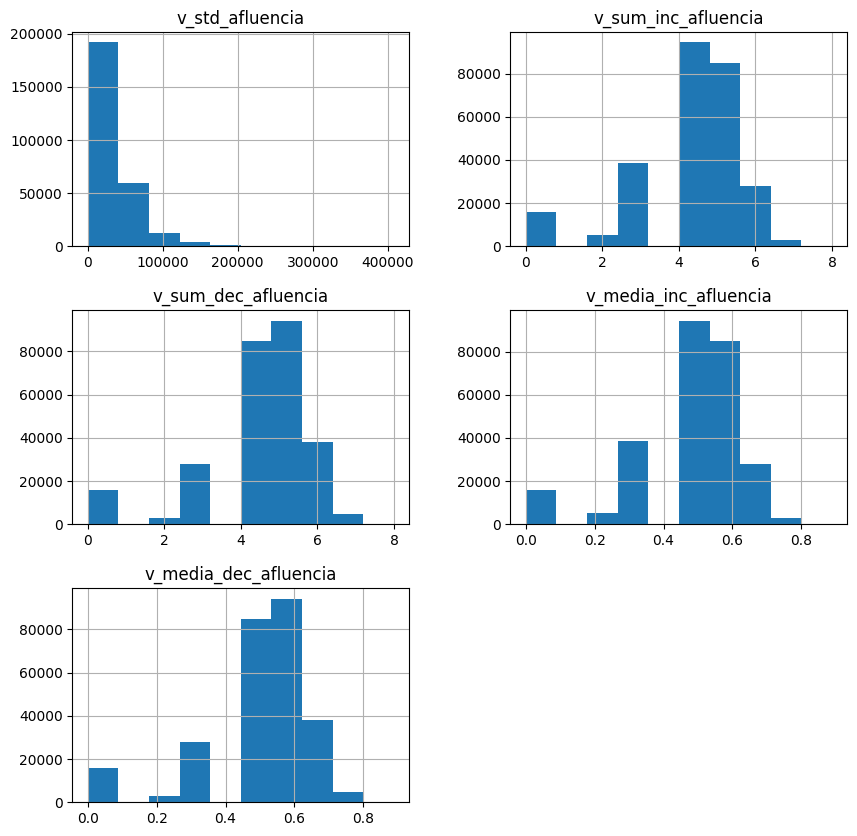

In [26]:
X[varc[4:9]].hist(figsize=(10,10))

### Análisis Univariado

#### Valores Ausentes

In [27]:
miss = 1 - X[varc].describe().T[['count']] / len(tad)

In [28]:
miss

,count
v_sum_afluencia,0.000000
v_min_afluencia,0.000000
v_mean_afluencia,0.000000
v_max_afluencia,0.000000
v_std_afluencia,0.000000
v_sum_inc_afluencia,0.000000
v_sum_dec_afluencia,0.000000
v_media_inc_afluencia,0.000000
v_media_dec_afluencia,0.000000
v_delta_min_afluencia,0.000000


In [29]:
X.shape , X.dropna().shape , X.dropna().shape[0] / X.shape[0]

((269100, 21), (269100, 21), 1.0)

#### Imputación

In [32]:
# Esto puede ser tan complejo o sofisticado como negocio o la variable lo requiera
im = SimpleImputer(strategy='median')

In [33]:
im.fit(X)

SimpleImputer(strategy='median')

In [34]:
X[varc] = im.transform(X[varc]) 

In [35]:
X

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,"1,538,718.000000","39,059.000000","153,871.800000","257,761.000000","91,233.811354",5.000000,4.000000,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2.000000,2.000000,1.000000,0.666667
1,"2,358,299.000000","48,321.000000","235,829.900000","368,193.000000","106,206.846405",3.000000,6.000000,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1.000000,3.000000,0.428571,1.500000
2,"375,640.000000","17,515.000000","37,564.000000","54,652.000000","12,687.905685",3.000000,6.000000,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1.000000,3.000000,0.428571,1.500000
3,"1,760,254.000000","40,677.000000","176,025.400000","253,680.000000","71,681.461608",7.000000,2.000000,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3.000000,1.000000,2.333333,0.250000
4,"1,938,085.000000","82,758.000000","193,808.500000","255,863.000000","53,239.580955",4.000000,5.000000,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2.000000,3.000000,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
269096,"612,947.000000","38,902.000000","61,294.700000","71,912.000000","11,646.379953",5.000000,4.000000,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3.000000,2.000000,1.000000,0.666667
269097,"2,885,651.000000","269,899.000000","288,565.100000","336,441.000000","20,369.570614",5.000000,4.000000,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3.000000,3.000000,1.000000,0.666667
269098,"2,310,010.000000","140,453.000000","231,001.000000","280,277.000000","47,489.221879",6.000000,3.000000,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3.000000,1.000000,1.500000,0.428571


#### Distribución Alterada

In [36]:
ks = pd.DataFrame(  map(  lambda v: (v ,   ks_2samp( tad[v].dropna() , X[v] ).statistic  ) , varc  )  , columns=['var','ks']  )

In [37]:
## Valores mayores a .1  se consideran distribuciones alteradas ( variables "rotas" )
ks

,var,ks
0,v_sum_afluencia,0.000000
1,v_min_afluencia,0.000000
2,v_mean_afluencia,0.000000
3,v_max_afluencia,0.000000
4,v_std_afluencia,0.000000
5,v_sum_inc_afluencia,0.000000
6,v_sum_dec_afluencia,0.000000
7,v_media_inc_afluencia,0.000000
8,v_media_dec_afluencia,0.000000
9,v_delta_min_afluencia,0.000000


#### Varianza

In [38]:
vt = VarianceThreshold(threshold=1)

In [39]:
vt.fit(X[varc])

VarianceThreshold(threshold=1)

In [40]:
sin_varianza = [ v for v,u in zip( varc , vt.get_support()  ) if not(u)  ]

In [42]:
len(sin_varianza),sin_varianza

(7,
 ['v_media_inc_afluencia',
  'v_media_dec_afluencia',
  'v_pct_delta_min_afluencia',
  'v_max_racha_inc_afluencia',
  'v_max_racha_dec_afluencia',
  'v_media_racha_inc_afluencia',
  'v_media_racha_dec_afluencia'])

array([[<Axes: title={'center': 'v_media_inc_afluencia'}>,
        <Axes: title={'center': 'v_media_dec_afluencia'}>,
        <Axes: title={'center': 'v_pct_delta_min_afluencia'}>],
       [<Axes: title={'center': 'v_max_racha_inc_afluencia'}>,
        <Axes: title={'center': 'v_max_racha_dec_afluencia'}>,
        <Axes: title={'center': 'v_media_racha_inc_afluencia'}>],
       [<Axes: title={'center': 'v_media_racha_dec_afluencia'}>,
        <Axes: >, <Axes: >]], dtype=object)

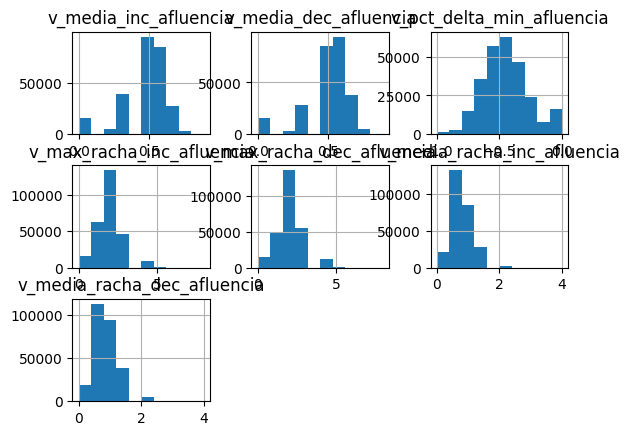

In [46]:
X[sin_varianza].hist()

In [48]:
varc = [v for v in varc if v not in sin_varianza]

In [49]:
len(varc), varc

(14,
 ['v_sum_afluencia',
  'v_min_afluencia',
  'v_mean_afluencia',
  'v_max_afluencia',
  'v_std_afluencia',
  'v_sum_inc_afluencia',
  'v_sum_dec_afluencia',
  'v_delta_min_afluencia',
  'v_delta_max_afluencia',
  'v_delta_mean_afluencia',
  'v_delta_desv_afluencia',
  'v_pct_delta_max_afluencia',
  'v_pct_delta_mean_afluencia',
  'v_pct_delta_desv_afluencia'])

In [50]:
X.drop( sin_varianza , axis=1 , inplace=True  )

#### Extremos

In [58]:
ext = X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index()
for v, li, ls in ext.values:
    X[f'ol_{v}'] = ( ( X[v] < li ) | (X[v] > ls) ).astype(int)

X['ext'] = X.filter(like='ol_').max(axis=1)
X.drop(X.filter(like='ol_').columns , axis=1 , inplace=True)
X['ext'].value_counts(True)

ext
0   0.944615
1   0.055385
Name: proportion, dtype: float64

In [55]:
X.shape , tad.shape

((269100, 15), (269100, 25))

In [64]:
# Antes de eliminar "renglones" asegurar que se tiene la unidad muestar , el id, el identificador, ... etc...
X[um + ['ancla']] = tad[ um +['ancla'] ]

In [66]:
X = X.loc[ X['ext'] == 0 ].reset_index(drop=True).drop(['ext'],axis=1)

In [67]:
X.shape , tad.shape

((254196, 16), (269100, 25))

In [68]:
254196 / 269100

0.9446153846153846

### Multivariado

In [70]:
X[varc].corr()

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia
v_sum_afluencia,1.000000,0.936017,1.000000,0.987902,0.862413,0.224842,0.266802,-0.826711,0.843477,0.006354,0.849453,0.076027,0.027979,0.086141
v_min_afluencia,0.936017,1.000000,0.936017,0.906045,0.665847,0.205705,0.226705,-0.640902,0.650678,0.001848,0.659148,-0.150396,-0.160345,-0.136629
v_mean_afluencia,1.000000,0.936017,1.000000,0.987902,0.862413,0.224842,0.266802,-0.826711,0.843477,0.006354,0.849453,0.076027,0.027979,0.086141
v_max_afluencia,0.987902,0.906045,0.987902,1.000000,0.908600,0.224169,0.276564,-0.862229,0.878443,0.005533,0.892714,0.129443,0.085964,0.147711
v_std_afluencia,0.862413,0.665847,0.862413,0.908600,1.000000,0.207690,0.273747,-0.930745,0.943380,0.007568,0.974320,0.376010,0.329492,0.408914
v_sum_inc_afluencia,0.224842,0.205705,0.224842,0.224169,0.207690,1.000000,0.145941,-0.238616,0.157524,0.210013,0.201817,0.196007,0.235919,0.244893
v_sum_dec_afluencia,0.266802,0.226705,0.266802,0.276564,0.273747,0.145941,1.000000,-0.216928,0.299184,-0.198017,0.267341,0.348293,0.128276,0.384386
v_delta_min_afluencia,-0.826711,-0.640902,-0.826711,-0.862229,-0.930745,-0.238616,-0.216928,1.000000,-0.881188,0.082734,-0.955993,-0.330405,-0.283563,-0.371595
v_delta_max_afluencia,0.843477,0.650678,0.843477,0.878443,0.943380,0.157524,0.299184,-0.881188,1.000000,0.074850,0.958775,0.441477,0.361129,0.443746
v_delta_mean_afluencia,0.006354,0.001848,0.006354,0.005533,0.007568,0.210013,-0.198017,0.082734,0.074850,1.000000,0.003852,0.089865,0.383770,0.069896


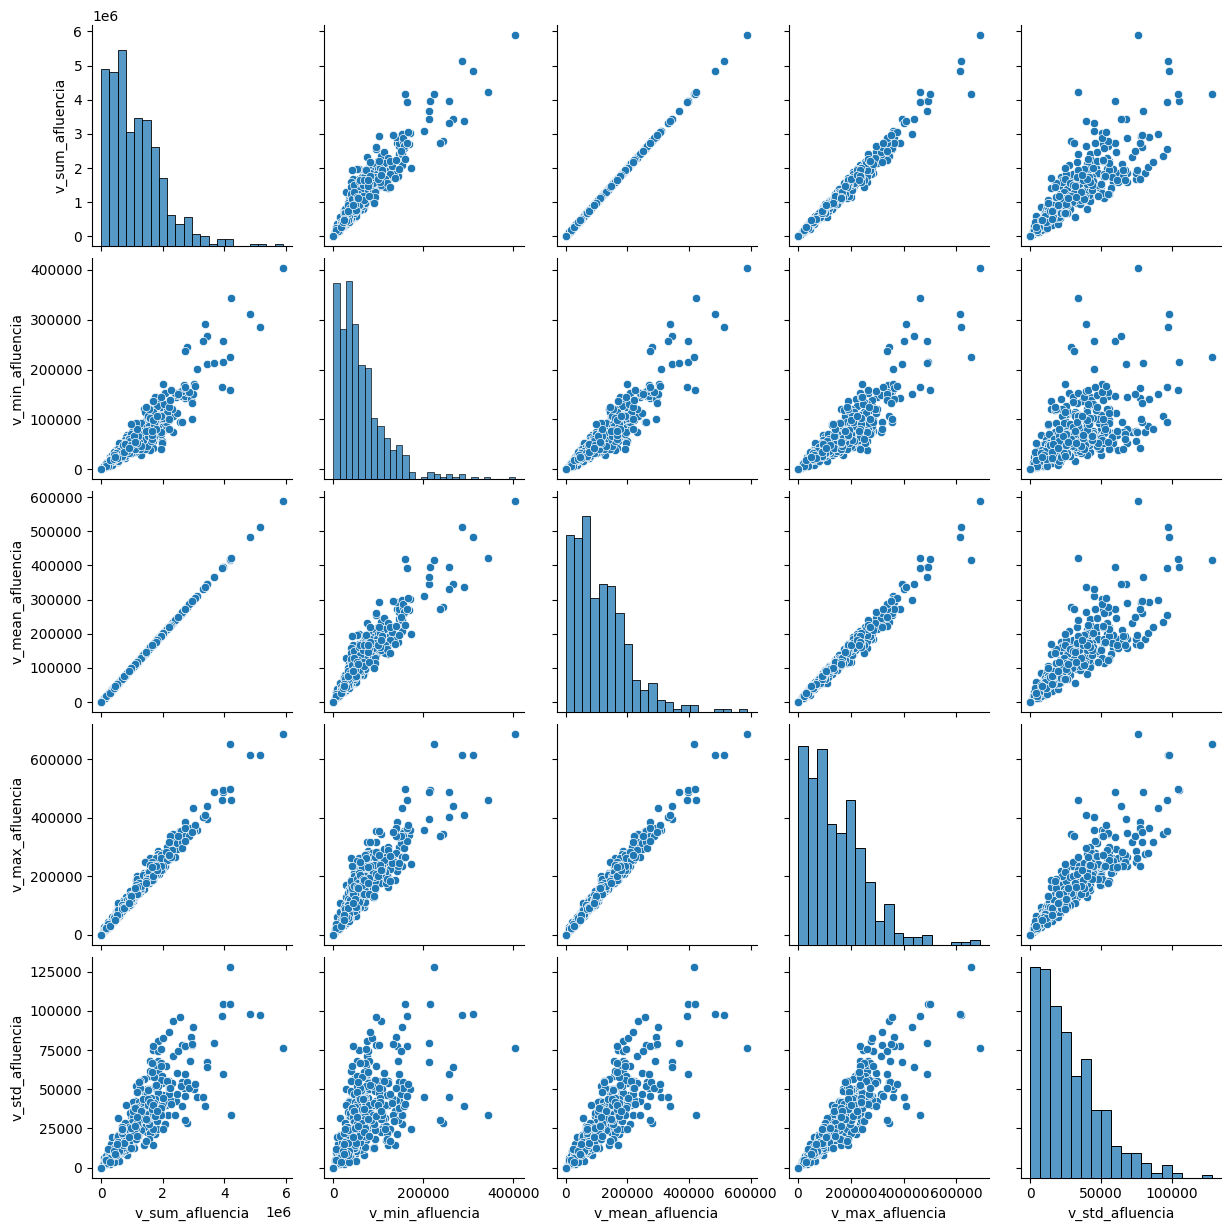

In [73]:
sns.pairplot(X[varc[:5]].sample(500) )

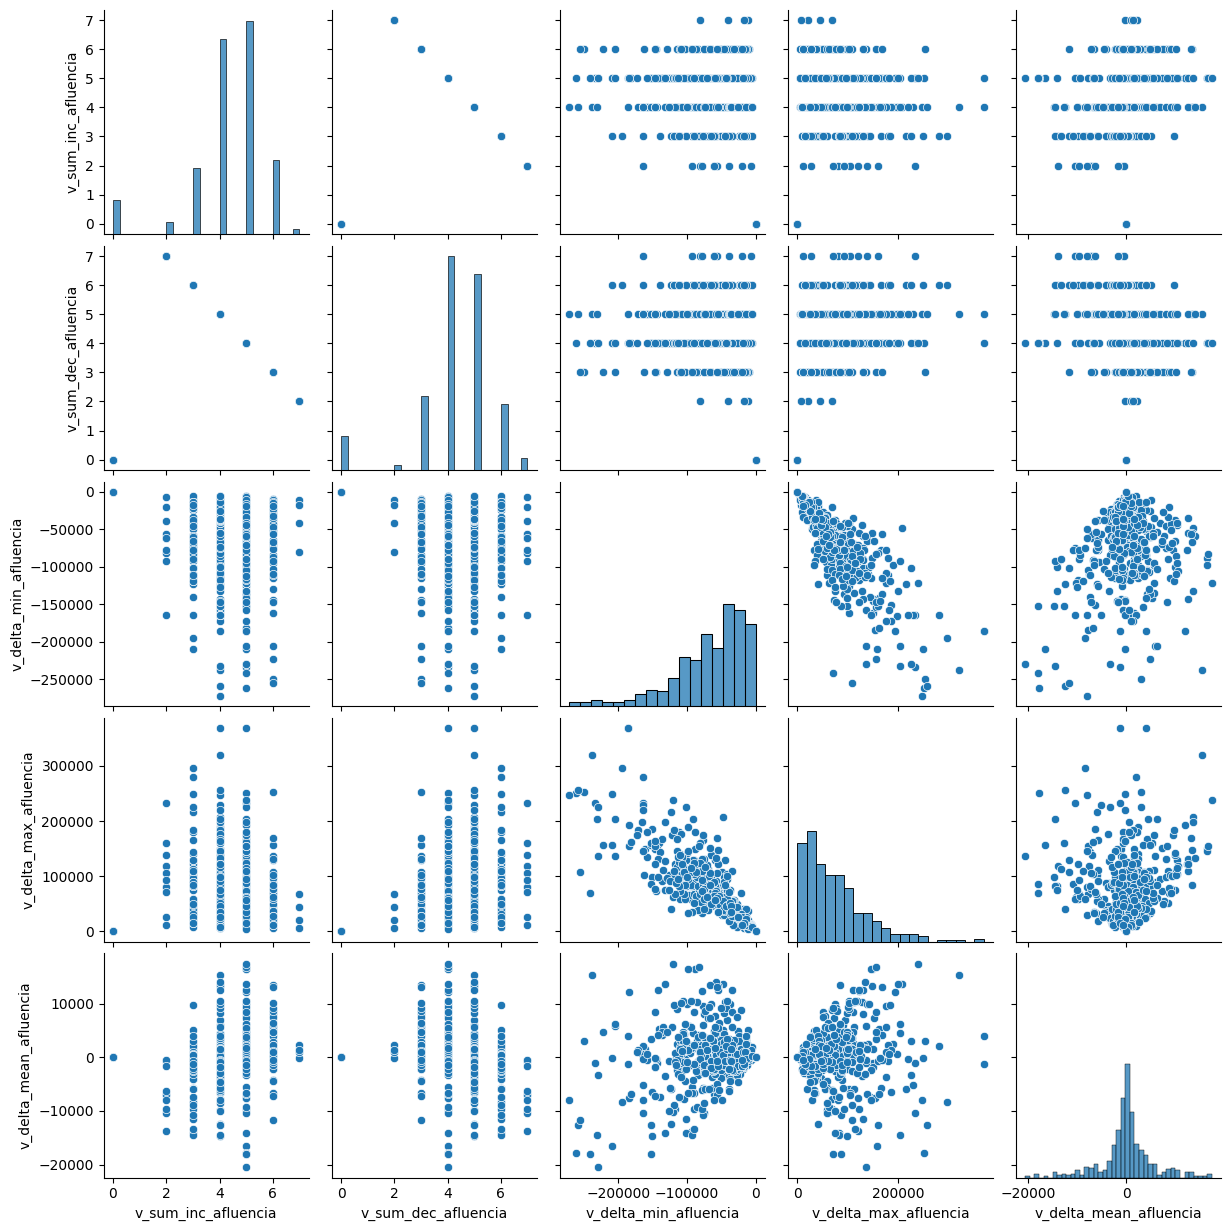

In [74]:
sns.pairplot(X[varc[5:10]].sample(500) )

### Multicolinealidad 

In [76]:
vc = VarClusHi( df= X[varc] , feat_list=varc )
# Aquí se genera el cluster
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values( by=['Cluster','RS_Ratio'] , ascending=[1,1] ).reset_index(drop=True)
rs['id'] = rs.groupby( 'Cluster' ).cumcount() + 1

In [77]:
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,v_max_afluencia,0.972240,0.030658,0.028638,1
1,0,v_sum_afluencia,0.940992,0.028310,0.060728,2
2,0,v_mean_afluencia,0.940992,0.028310,0.060728,3
3,0,v_std_afluencia,0.904189,0.156156,0.113541,4
4,0,v_delta_desv_afluencia,0.901795,0.177623,0.119416,5
5,0,v_delta_max_afluencia,0.866820,0.187573,0.163928,6
6,0,v_delta_min_afluencia,0.847848,0.126803,0.174248,7
7,0,v_min_afluencia,0.718356,0.021102,0.287716,8
8,1,v_pct_delta_desv_afluencia,0.963200,0.061338,0.039205,1
9,1,v_pct_delta_max_afluencia,0.933246,0.050705,0.070320,2


In [78]:
varc = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()

In [79]:
varc

['v_max_afluencia', 'v_pct_delta_desv_afluencia', 'v_delta_mean_afluencia']

array([[<Axes: title={'center': 'v_max_afluencia'}>,
        <Axes: title={'center': 'v_pct_delta_desv_afluencia'}>],
       [<Axes: title={'center': 'v_delta_mean_afluencia'}>, <Axes: >]],
      dtype=object)

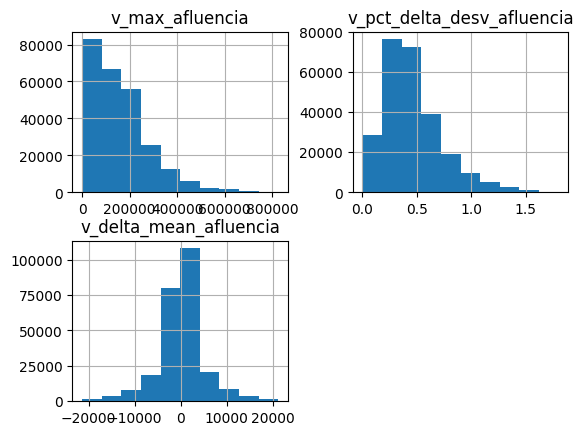

In [80]:
X[varc].hist()

# TAD Final - Modelo 1

In [81]:
X[ um + ['ancla'] + varc ]

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222"
1,Est00002,10,"54,652.000000",0.641499,21.222222
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444"
3,Est00004,10,"255,863.000000",0.407847,307.555556
4,Est00005,10,"18,637.000000",0.290186,-276.555556
...,...,...,...,...,...
254191,Est00385,699,405.000000,0.000000,0.000000
254192,Est00386,699,"71,912.000000",0.370158,198.777778
254193,Est00387,699,"336,441.000000",0.090890,"3,205.222222"
254194,Est00388,699,"280,277.000000",0.350651,"13,233.666667"


In [87]:
y

,id_estacion,ancla,y
0,Est00000,10,"233,986.000000"
1,Est00001,10,"290,042.000000"
2,Est00002,10,"40,779.000000"
3,Est00003,10,"232,123.000000"
4,Est00004,10,"228,464.000000"
...,...,...,...
269095,Est00385,699,405.000000
269096,Est00386,699,"64,261.000000"
269097,Est00387,699,NaN
269098,Est00388,699,"266,479.000000"


In [88]:
y2

,id_estacion,ancla,y2
0,Est00000,10,1
1,Est00001,10,1
2,Est00002,10,0
3,Est00003,10,1
4,Est00004,10,1
...,...,...,...
269095,Est00385,699,0
269096,Est00386,699,0
269097,Est00387,699,1
269098,Est00388,699,1


In [89]:
tad_1 = X[ um + ['ancla'] + varc ].merge( y , on = [ 'id_estacion','ancla'] , how='inner' ).reset_index(drop=True)

In [91]:
tad_1.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222","233,986.000000"
1,Est00002,10,"54,652.000000",0.641499,21.222222,"40,779.000000"
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444","232,123.000000"
3,Est00004,10,"255,863.000000",0.407847,307.555556,"228,464.000000"
4,Est00005,10,"18,637.000000",0.290186,-276.555556,"17,121.000000"


In [92]:
tad_2 = X[ um + ['ancla'] + varc ].merge( y2 , on = [ 'id_estacion','ancla'] , how='inner' ).reset_index(drop=True)

In [94]:
tad_2.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222",1
1,Est00002,10,"54,652.000000",0.641499,21.222222,0
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444",1
3,Est00004,10,"255,863.000000",0.407847,307.555556,1
4,Est00005,10,"18,637.000000",0.290186,-276.555556,0


In [95]:
tad_1.to_parquet("tad_01_estaciones.parquet")
tad_2.to_parquet("tad_02_estaciones.parquet")

# Modelo (1): Regresión

In [97]:
tad_1.shape , tad_1.loc[ ~tad_1['y'].isna() ].shape

((254196, 6), (254076, 6))

In [99]:
# Eliminamos los renglones/registros donde no se cuenta con la variable objetivo
tad_1 = tad_1.loc[ ~tad_1['y'].isna() ].reset_index(drop=True)

<Axes: >

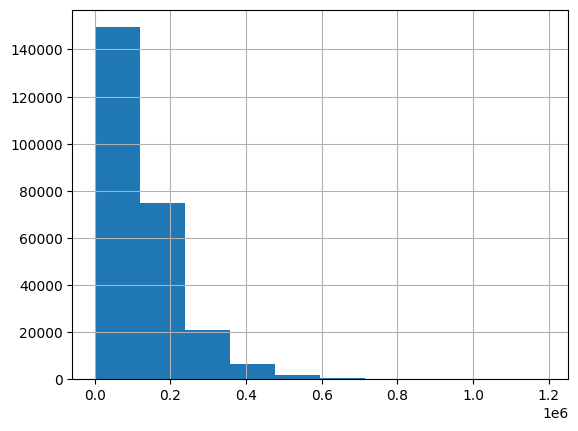

In [100]:
tad_1['y'].hist()

In [101]:
tad_1.loc[ tad_1['y'] < 600000  ].shape[0] / tad_1.shape[0]

0.997701475149168

In [103]:
tad_1 = tad_1.loc[ tad_1['y'] < 600000  ].reset_index(drop=True)

<Axes: >

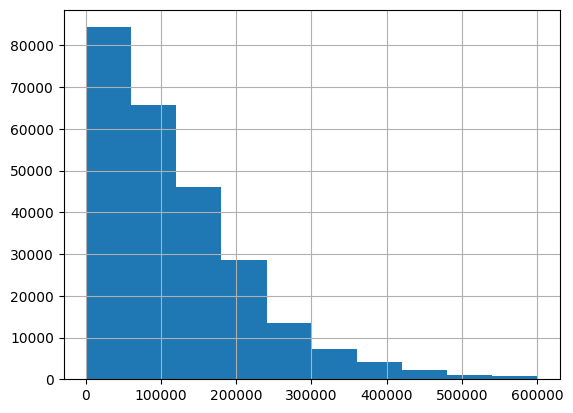

In [105]:
tad_1['y'].hist()

### Partición de datos

In [106]:
Xt, Xv, yt, yv = train_test_split( tad_1[varc] , tad_1['y'] , train_size=0.7 )

In [107]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((177444, 3), (177444,), (76048, 3), (76048,))

### Modelo / Entrenamiento - Regresión

In [108]:
modelo_1 = LinearRegression(n_jobs=-1)

In [109]:
modelo_1.fit( Xt , yt )

LinearRegression(n_jobs=-1)

### Parámetros del modelo

In [110]:
modelo_1.intercept_ , modelo_1.coef_

(np.float64(5929.650663832086),
 array([ 7.56441754e-01, -1.00556106e+04,  2.21519328e-01]))

### Evaluación del modelo

In [112]:
mean_absolute_error( y_pred= modelo_1.predict(Xt) , y_true=yt )

26346.741988512702

In [111]:
mean_absolute_error( y_pred= modelo_1.predict(Xv) , y_true=yv )

26438.14528540937

### Visualizaciones

(array([24823., 20289., 16627.,  7587.,  3602.,  1845.,   731.,   392.,
          121.,    31.]),
 array([  1064.5543868 ,  63819.7004122 , 126574.84643759, 189329.99246299,
        252085.13848838, 314840.28451377, 377595.43053917, 440350.57656456,
        503105.72258996, 565860.86861535, 628616.01464075]),
 <BarContainer object of 10 artists>)

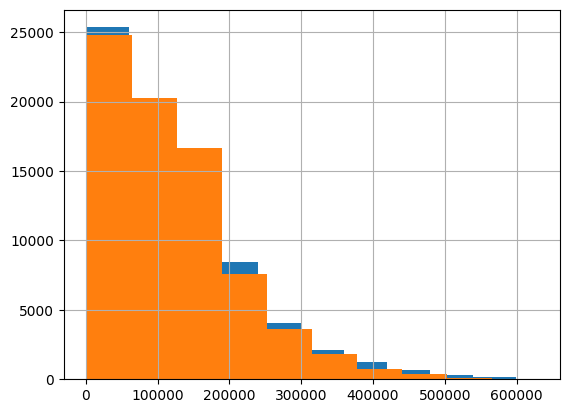

In [114]:
yv.hist()
plt.hist( modelo_1.predict(Xv)  )

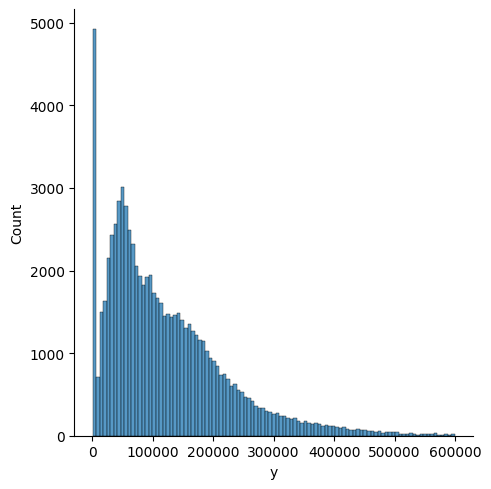

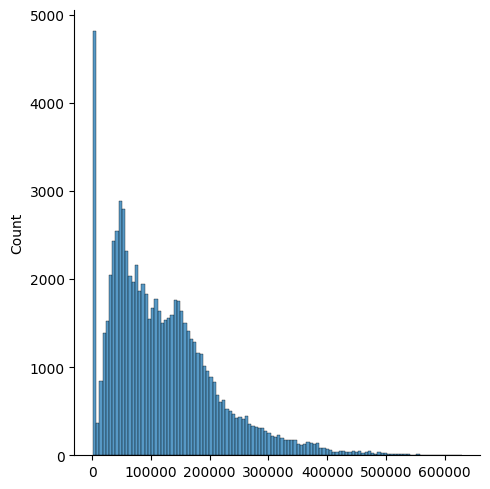

In [129]:
sns.displot( yv , kde_kws = {'cumulative':True} )
sns.displot(  modelo_1.predict(Xv[varc]) , kde_kws = {'cumulative':True} )

In [120]:
Xv['y'] = yv
Xv['y^'] = modelo_1.predict(Xv[varc])

In [122]:
Xv['error'] = Xv['y'] - Xv['y^']

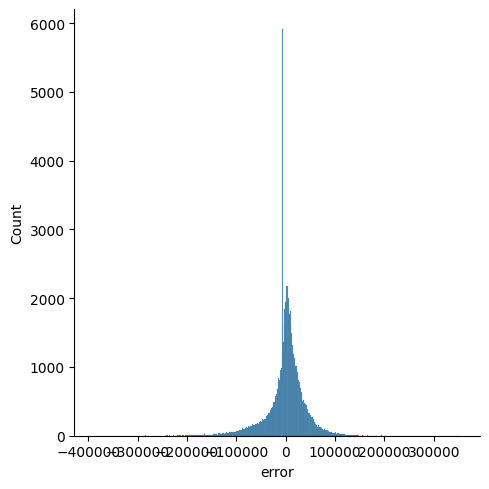

In [127]:
sns.displot( Xv['error'] , kde_kws = {'cumulative':True} )

<Axes: >

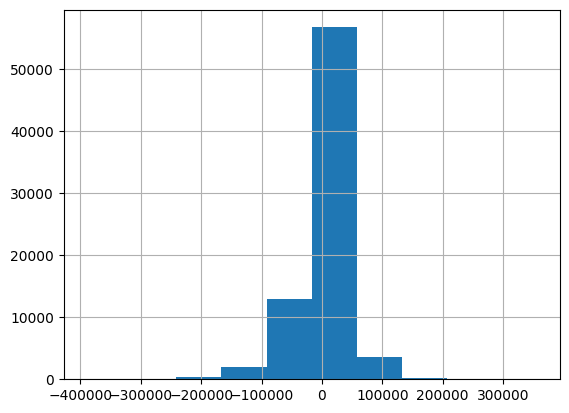

In [124]:
Xv['error'].hist()

In [130]:
Xv['error'].describe(percentiles=np.arange(0,1.01,.1))

count     76,048.000000
mean         187.578454
std       40,751.861552
min     -390,548.372365
0%      -390,548.372365
10%      -44,051.392546
20%      -17,502.628407
30%       -5,831.009574
40%       -2,955.065417
50%        2,421.777338
60%        7,631.817327
70%       14,346.270713
80%       24,157.791352
90%       40,964.281384
100%     356,229.203176
max      356,229.203176
Name: error, dtype: float64

## Modelo (2): Clasificación

In [132]:
tad_2.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222",1
1,Est00002,10,"54,652.000000",0.641499,21.222222,0
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444",1
3,Est00004,10,"255,863.000000",0.407847,307.555556,1
4,Est00005,10,"18,637.000000",0.290186,-276.555556,0


In [134]:
tad_2['y2'].value_counts(), tad_2['y2'].value_counts(1)*100

(y2
 0    130775
 1    123421
 Name: count, dtype: int64,
 y2
 0   51.446522
 1   48.553478
 Name: proportion, dtype: float64)

In [137]:
X2 = tad_2[varc]
y2 = tad_2['y2']

### Partición de datos

In [138]:
X2t, X2v, y2t, y2v = train_test_split( X2 , y2 , train_size=0.7 )

In [139]:
X2t.shape, y2t.shape, X2v.shape, y2v.shape

((177937, 3), (177937,), (76259, 3), (76259,))

### Modelo / Entrenamiento - Regresión Logística

In [140]:
modelo_2 = LogisticRegression(n_jobs=-1)

In [141]:
modelo_2.fit(X2t,y2t)

LogisticRegression(n_jobs=-1)

In [142]:
modelo_2.coef_ , modelo_2.intercept_

(array([[ 3.50877271e-05, -6.42480833e-01,  1.97167004e-05]]),
 array([-4.71343131]))

## Evaluar modelo

In [145]:
pd.DataFrame(modelo_2.predict_proba( X2v ))

,0,1
0,0.806154,0.193846
1,0.990980,0.009020
2,0.004141,0.995859
3,0.073566,0.926434
4,0.795073,0.204927
...,...,...
76254,0.342839,0.657161
76255,0.826777,0.173223
76256,0.963810,0.036190
76257,0.990980,0.009020


In [151]:
Xv['y2^'] = pd.DataFrame(modelo_2.predict( X2v ))

In [153]:
Xv['y2^'].value_counts(1)*100

y2^
0.000000   52.791767
1.000000   47.208233
Name: proportion, dtype: float64

In [154]:
X2v['y2'] = y2v

In [155]:
X2v['y2'].value_counts(1)*100

y2
0   51.344759
1   48.655241
Name: proportion, dtype: float64

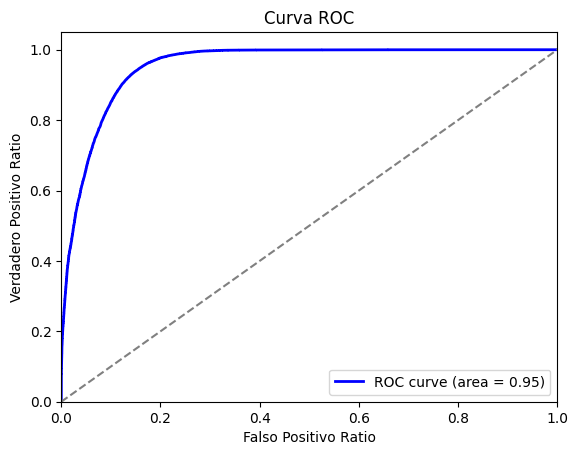

In [159]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y2v
y_scores = modelo_2.predict_proba(X2v[varc])[:,1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Falso Positivo Ratio")
plt.ylabel("Verdadero Positivo Ratio")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [161]:
def metricas(model,Xv,yv):
    print(" Métricas para modelo de clasificación: \n")

    print(" Valor ROC : %.3f"   %roc_auc_score( y_score=model.predict_proba(Xv)[:,1] , y_true=yv  )   )

    print(" Valor ACC : %.3f\n" %accuracy_score( y_pred=model.predict(Xv) , y_true=yv) )

    print(" Matriz de confusión: ", "\n", confusion_matrix(y_pred=model.predict(Xv) , y_true=yv ) )

In [163]:
metricas(modelo_2 , X2v[varc], y2v)

 Métricas para modelo de clasificación: 

 Valor ROC : 0.954
 Valor ACC : 0.879

 Matriz de confusión:  
 [[35085  4070]
 [ 5146 31958]]
